# Collective Effects - Bipolar Isotropic Gas with Spectrum

In [ ]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.integrate as integrate
import math 
from ipywidgets import interact, interactive, fixed, interact_manual
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.animation import FuncAnimation
from scipy.special import gamma

from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
G_F=1.1663787*10**(-23) #eV⁻² - Fermi Constant
delta_m2_31=2.5*10**(-3) #eV² - \Delta m²_31
#theta_31=np.arcsin(math.sqrt(2.18*10**-2)) #\theta_31
theta_31=10**(-2)#\theta_31
N_A=6.02*10**(23) #Avogadro constant
from_eV_to_1_over_m=8.065543937*10**5
from_eV_to_1_over_km=from_eV_to_1_over_m*10**(3)

#Calculate the effective mass squared difference in matter
def delta_m2_eff(delta_m2,theta,Acc):
  delta = math.sqrt((delta_m2*np.cos(2*theta)-Acc)**2+(delta_m2*np.sin(2*theta))**2)
  return delta

#Calculate the effective mixing angle in matter
def theta_eff(delta_m2,theta,Acc):
  theta_eff=(1/2)*math.atan2(1,1/((math.tan(2*theta))/(1-(Acc/(delta_m2*np.cos(2*theta))))))
  return theta_eff

#Calculate the matter "Potential" - Acc=2EV_cc
def Acc(N_e,E):
  A = 2*math.sqrt(2)*E*G_F*N_e
  return A

def B_vec(E):
  E=E*10**6 #From MeV to eV
  B=delta_m2_31/(2*E)
  B1=B*np.sin(2*theta_31)
  B2=0
  B3=B*np.cos(2*theta_31)
  return B,B1,B2,B3

# 1.Energy Distribution

### Supernova Spectrum

In [ ]:
def phi(E,E_0,alpha):
  N=((alpha+1)**(alpha+1))/(E_0*gamma(alpha+1))
  R=N*((E/E_0)**alpha)*math.exp((-1)*(alpha+1)*E/E_0)
  return R
phi_vec= np.vectorize(phi)

print("Testing the espectrum normalization:",integrate.quad(lambda E: phi(E,14,2.3), 0, 100)[0])

Testing the espectrum normalization: 0.9999999658440586


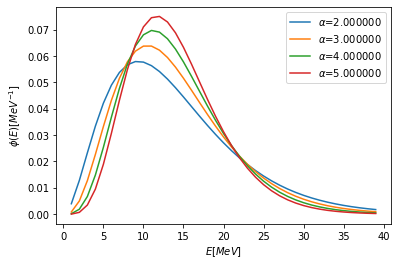

In [ ]:
E_step=1
E_vec=np.arange(1,40,E_step)
E_0=14
alpha=np.arange(2, 6, 1)

for i in range(len(alpha)):
  plt.plot(E_vec,phi_vec(E_vec,E_0,alpha[i]),label=r'$\alpha$=%f'%(alpha[i]))
  plt.xlabel(r'$E[MeV]$')
  plt.ylabel(r'$\phi(E) [MeV^{-1}]$')
plt.legend(loc='upper right')

### Initial Conditions - Discretazing the Spectrum

In [ ]:
E_step=0.5
E_vec=np.arange(1,40,E_step)
E_0=8
nu_spec=phi_vec(E_vec,E_0,2.3)*E_step
antinu_spec=0.5*phi_vec(E_vec,E_0+15,2.3)*E_step

y0=[] #Initial state

for i in range(len(nu_spec)):
  y0.append(0)
  y0.append(0)
  y0.append(nu_spec[i])
  y0.append(0)
  y0.append(0)
  y0.append(antinu_spec[i])

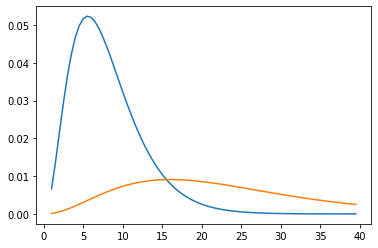

In [ ]:
plt.plot(E_vec,nu_spec)
plt.plot(E_vec,antinu_spec)

### System of Equations


$$\frac{d}{dt}\vec{P}_{\nu,\vec{p}_1} = \vec{P}_{\nu,\vec{p}_1}   \times \left [ \vec{B} + \mu \sum_{\vec{p}_2} [\vec{P}_{\nu,\vec{p}_2} -\vec{P}_{\overline{\nu},\vec{p}_2} ] \right]$$

In [ ]:
def f_nu_antinu_coupled(y, t, params):
    B1, B2, B3, mu= params  # unpack parameters
    derivs=[]
    nu1, nu2, nu3, antinu1, antinu2, antinu3 = [],[],[],[],[],[]
    for i in range(int(len(y)/6)):
      nu1.append(y[(i*6)])
      nu2.append(y[(i*6)+1])
      nu3.append(y[(i*6)+2]) 
      antinu1.append(y[(i*6)+3]) 
      antinu2.append(y[(i*6)+4]) 
      antinu3.append(y[(i*6)+5])    # unpack current values of y

    # list of dy/dt=f functions
    for i in range(len(nu1)):
      derivs.append(nu2[i]*B3[i]-nu3[i]*B2[i] +mu*(nu2[i]*np.sum(antinu3)-nu3[i]*np.sum(antinu2)))  
      derivs.append(nu3[i]*B1[i]-nu1[i]*B3[i] +mu*(nu3[i]*np.sum(antinu1)-nu1[i]*np.sum(antinu3)))
      derivs.append(nu1[i]*B2[i]-nu2[i]*B1[i] +mu*(nu1[i]*np.sum(antinu2)-nu2[i]*np.sum(antinu1)))
      derivs.append(-1*(antinu2[i]*B3[i]-antinu3[i]*B2[i]) +mu*(np.sum(nu2)*antinu3[i]-np.sum(nu3)*antinu2[i]))      
      derivs.append(-1*(antinu3[i]*B1[i]-antinu1[i]*B3[i]) +mu*(np.sum(nu3)*antinu1[i]-np.sum(nu1)*antinu3[i]))
      derivs.append(-1*(antinu1[i]*B2[i]-antinu2[i]*B1[i]) +mu*(np.sum(nu1)*antinu2[i]-np.sum(nu2)*antinu1[i]))       
           
    return derivs


In [ ]:
#time
t_bins=1000
t_max = 4*(2*np.pi/min(B_vec(E_vec)[0])) #eV⁻¹
t_step = (2*np.pi/max(B_vec(E_vec)[0]))/20 #eV⁻¹
t_vec = np.arange(0., t_max , t_step) #eV⁻¹
 

# Parameters for ODE solver
B1,B2,B3=[],[],[]
for E in E_vec:      
  B1.append(B_vec(E)[1])
  B2.append(B_vec(E)[2])
  B3.append(B_vec(E)[3])

mu=np.max(B_vec(E_vec)[0])
params = np.array([B1, B2, B3,mu])


#f_nu_antinu_coupled(y0,0,params)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


### Solve the system

In [ ]:
psoln_NH= odeint(f_nu_antinu_coupled, y0, t_vec, args=(np.array([B1, B2, B3,mu]),))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
psoln_IH= odeint(f_nu_antinu_coupled, y0, t_vec, args=(np.array([-1*np.asarray(B1),-1*np.asarray(B2),-1*np.asarray(B3),mu]),))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
#psoln_trans=np.transpose(psoln,(1,0))
nu1_NH, nu2_NH, nu3_NH, antinu1_NH, antinu2_NH, antinu3_NH = [],[],[],[],[],[]
nu1_IH, nu2_IH, nu3_IH, antinu1_IH, antinu2_IH, antinu3_IH = [],[],[],[],[],[]

for j in range(len(t_vec)):
  nu1_NH.append([])
  nu2_NH.append([])
  nu3_NH.append([])
  nu1_IH.append([])
  nu2_IH.append([])
  nu3_IH.append([])
  antinu1_NH.append([])
  antinu2_NH.append([]) 
  antinu3_NH.append([])
  antinu1_IH.append([])
  antinu2_IH.append([]) 
  antinu3_IH.append([])
  for i in range(len(E_vec)):
    nu1_NH[j].append(psoln_NH[j][(i*6)])
    nu2_NH[j].append(psoln_NH[j][(i*6)+1])
    nu3_NH[j].append(psoln_NH[j][(i*6)+2])
    antinu1_NH[j].append(psoln_NH[j][(i*6)+3])
    antinu2_NH[j].append(psoln_NH[j][(i*6)+4]) 
    antinu3_NH[j].append(psoln_NH[j][(i*6)+5])
    
    nu1_IH[j].append(psoln_IH[j][(i*6)])
    nu2_IH[j].append(psoln_IH[j][(i*6)+1])
    nu3_IH[j].append(psoln_IH[j][(i*6)+2])
    antinu1_IH[j].append(psoln_IH[j][(i*6)+3])
    antinu2_IH[j].append(psoln_IH[j][(i*6)+4]) 
    antinu3_IH[j].append(psoln_IH[j][(i*6)+5])

Text(0.5, 0, 'E [MeV]')

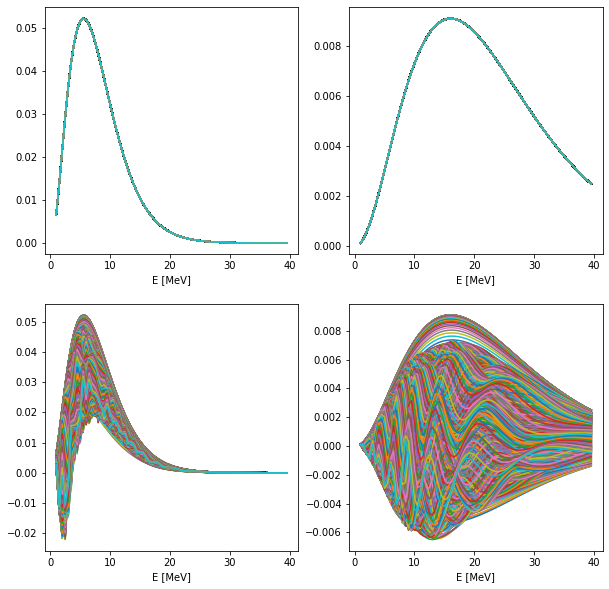

In [ ]:
# Plot results
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
for i in range(len(t_vec)):
  plt.plot(E_vec, np.array(nu3_NH[i]),label=t_vec[i])
#plt.ylim(0.0,0.07)
plt.xlabel('E [MeV]')

plt.subplot(2,2,2)
for i in range(len(t_vec)):
  plt.plot(E_vec,(antinu3_NH[i]),label=t_vec[i])
#plt.ylim(0.0,0.07)
plt.xlabel('E [MeV]')
#plt.legend(loc='lower right')

plt.subplot(2,2,3)
for i in range(len(t_vec)):
  plt.plot(E_vec, np.array(nu3_IH[i]),label=t_vec[i])
#plt.ylim(0.0,0.07)
plt.xlabel('E [MeV]')

plt.subplot(2,2,4)
for i in range(len(t_vec)):
  plt.plot(E_vec,(antinu3_IH[i]),label=t_vec[i])
#plt.ylim(0.0,0.07)
plt.xlabel('E [MeV]')
#plt.legend(loc='lower right')

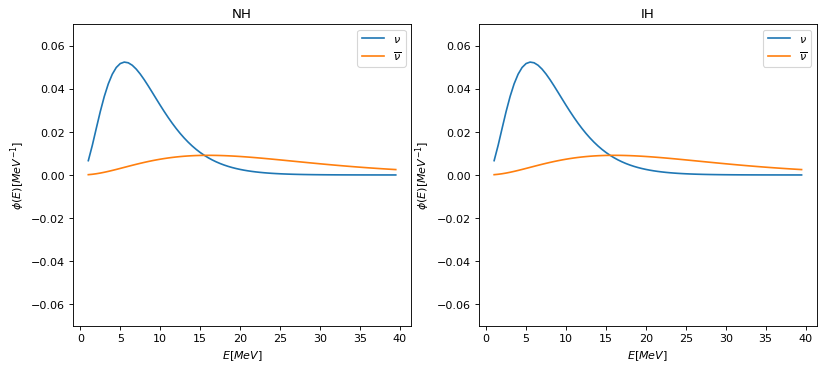

In [ ]:
from matplotlib.animation import FuncAnimation
t_step=1
t_f=len(t_vec)

fig = plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel(r'$E [MeV]$')
ax1.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
nu_NH, = ax1.plot(E_vec,nu3_NH[0],label=r'$\nu$')
antinu_NH, = ax1.plot(E_vec,antinu3_NH[0],label=r'$\overline{\nu}$')
ax1.set_ylim(-0.07,0.07)
#ax.set_yscale('log')
ax1.set_title("NH")
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel(r'$E [MeV]$')
ax2.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
nu_IH, = ax2.plot(E_vec,nu3_IH[0],label=r'$\nu$')
antinu_IH, = ax2.plot(E_vec,antinu3_IH[0],label=r'$\overline{\nu}$')
ax2.set_ylim(-0.07,0.07)
#ax.set_yscale('log')
ax2.set_title("IH")
ax2.legend(loc='upper right')

def update(t_i):
    nu_NH.set_data(E_vec,nu3_NH[t_i])
    antinu_NH.set_data(E_vec,antinu3_NH[t_i])
    nu_IH.set_data(E_vec,nu3_IH[t_i])
    antinu_IH.set_data(E_vec,antinu3_IH[t_i])
    #ax.set_title('Spectrum (10kpc)- t=%f s'%(t_data[0][t_i]))
    #max=np.amax(phi_aux)
    #ax.set_ylim(0, max)
    #print(max)

ani = FuncAnimation(fig, update, frames=np.arange(0,t_f,t_step), interval=100)

In [ ]:
HTML(ani.to_html5_video())

In [ ]:
from_eV_to_1_over_m=8.065543937*10**5
from_eV_to_1_over_km=from_eV_to_1_over_m*10**(3)
t_max = 4*(2*np.pi/min(B_vec(E_vec)[0]))
t_step = (2*np.pi/max(B_vec(E_vec)[0]))/20

In [ ]:
print("Omega max:",max(B_vec(E_vec)[0])*from_eV_to_1_over_km,"km⁻¹")
print("Distance step:",t_step/from_eV_to_1_over_km,"km")
print("--------------------------------------------------------")
print("Omega min:",min(B_vec(E_vec)[0])*from_eV_to_1_over_km,"km⁻¹")
print("Distance max:",t_max/from_eV_to_1_over_km,"km")

Omega max: 1.008192992125 km⁻¹
Distance step: 0.3116062775806604 km
--------------------------------------------------------
Omega min: 0.025851102362179485 km⁻¹
Distance max: 972.2115860516607 km


In [ ]:

print("Omega - max:",max(B_vec(E_vec)[0])/(2*np.pi),"min:", min(B_vec(E_vec)[0])/(2*np.pi))
print("Distance - initial:",t[0],", final:",t[-1],", time step:",t_step)

Omega - max: 1.989436788648692e-10 min: 5.101119970894081e-12
Distance - initial: 0.0 , final: 784141526336.0123 , time step: 251327412.28718343


# 2.$\mu$ changing in the evolution

In [ ]:
mu_0=(10)*max(B_vec(E_vec)[0])
R_0=4*10**4#m
R_0= R_0*(8*10**5) #eV⁻¹
def mu_supernova(r): # r in eV⁻¹
  if r<R_0:
    return mu_0
  return mu_0*(R_0/r)**4
mu_supernova_vec=np.vectorize(mu_supernova)

In [ ]:
t_max = 4*(2*np.pi/min(B_vec(E_vec)[0])) #eV⁻¹
t_step = (2*np.pi/max(B_vec(E_vec)[0]))/20 #eV⁻¹
t_vec = np.arange(0., 1000*t_step , t_step) #eV⁻¹

B1,B2,B3=[],[],[]
for E in E_vec:      
  B1.append(B_vec(E)[1])
  B2.append(B_vec(E)[2])
  B3.append(B_vec(E)[3])

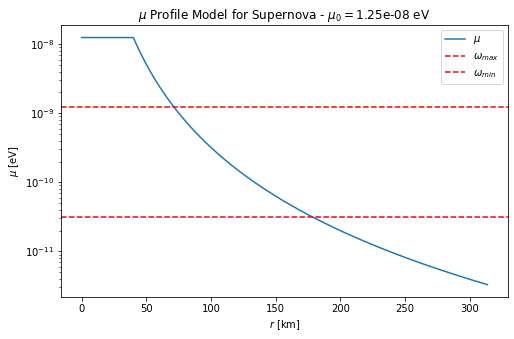

In [ ]:
fig = plt.figure(1, figsize=(8,5)) 
plt.plot(t_vec/(8*10**5)*10**-3,mu_supernova_vec(t_vec), label=r"$\mu$")
plt.axhline(y=max(B_vec(E_vec)[0]), color="red", linestyle="--", label=r'$\omega_{max}$')
plt.axhline(y=min(B_vec(E_vec)[0]), color="red", linestyle="--", label=r'$\omega_{min}$')
plt.xlabel(r'$r$ [km]')
plt.ylabel(r'$\mu$ [eV]')
plt.yscale('log')
plt.title(r"$\mu$ Profile Model for Supernova - $\mu_0=$%.2e eV"%(mu_0))
plt.legend()

In [ ]:
def f_nu_antinu_coupled_mu_var(y, time, params):
    B1, B2, B3= params  # unpack parameters
    mu=mu_supernova_vec(time)
    derivs=[]
    nu1, nu2, nu3, antinu1, antinu2, antinu3 = [],[],[],[],[],[]
    for i in range(int(len(y)/6)):
      nu1.append(y[(i*6)])
      nu2.append(y[(i*6)+1])
      nu3.append(y[(i*6)+2]) 
      antinu1.append(y[(i*6)+3]) 
      antinu2.append(y[(i*6)+4]) 
      antinu3.append(y[(i*6)+5])    # unpack current values of y

    # list of dy/dt=f functions
    for i in range(len(nu1)):
      derivs.append(nu2[i]*B3[i]-nu3[i]*B2[i] +
                    mu*(nu2[i]*(np.sum(antinu3)-np.sum(nu3))-nu3[i]*(np.sum(antinu2)-np.sum(nu2))))
      derivs.append(nu3[i]*B1[i]-nu1[i]*B3[i] +
                    mu*(nu3[i]*(np.sum(antinu1)-np.sum(nu1))-nu1[i]*(np.sum(antinu3)-np.sum(nu3))))
      derivs.append(nu1[i]*B2[i]-nu2[i]*B1[i] +
                    mu*(nu1[i]*(np.sum(antinu2)-np.sum(nu2))-nu2[i]*(np.sum(antinu1)-np.sum(nu1))))
      
      derivs.append(-1*(antinu2[i]*B3[i]-antinu3[i]*B2[i]) +
                    mu*(antinu2[i]*(np.sum(antinu3)-np.sum(nu3))-antinu3[i]*(np.sum(antinu2)-np.sum(nu2))))
      derivs.append(-1*(antinu3[i]*B1[i]-antinu1[i]*B3[i]) +
                    mu*(antinu3[i]*(np.sum(antinu1)-np.sum(nu1))-antinu1[i]*(np.sum(antinu3)-np.sum(nu3))))
      derivs.append(-1*(antinu1[i]*B2[i]-antinu2[i]*B1[i]) +
                    mu*(antinu1[i]*(np.sum(antinu2)-np.sum(nu2))-antinu2[i]*(np.sum(antinu1)-np.sum(nu1))))
    return derivs

In [ ]:
psoln_NH= odeint(f_nu_antinu_coupled_mu_var, y0, t_vec, args=(np.array([B1, B2, B3]),))

In [ ]:
psoln_IH= odeint(f_nu_antinu_coupled_mu_var, y0, t_vec, args=(np.array([-1*np.asarray(B1),-1*np.asarray(B2),-1*np.asarray(B3)]),))

In [ ]:
#psoln_trans=np.transpose(psoln,(1,0))
nu1_NH, nu2_NH, nu3_NH, antinu1_NH, antinu2_NH, antinu3_NH = [],[],[],[],[],[]
for j in range(len(psoln_NH)):
  nu1_NH.append([])
  nu2_NH.append([])
  nu3_NH.append([])
  antinu1_NH.append([])
  antinu2_NH.append([]) 
  antinu3_NH.append([])
  for i in range(len(E_vec)):
    nu1_NH[j].append(psoln_NH[j][(i*6)])
    nu2_NH[j].append(psoln_NH[j][(i*6)+1])
    nu3_NH[j].append(psoln_NH[j][(i*6)+2])
    antinu1_NH[j].append(psoln_NH[j][(i*6)+3])
    antinu2_NH[j].append(psoln_NH[j][(i*6)+4]) 
    antinu3_NH[j].append(psoln_NH[j][(i*6)+5])

nu1_IH, nu2_IH, nu3_IH, antinu1_IH, antinu2_IH, antinu3_IH = [],[],[],[],[],[]
for j in range(len(psoln_IH)):
  nu1_IH.append([])
  nu2_IH.append([])
  nu3_IH.append([])
  antinu1_IH.append([])
  antinu2_IH.append([]) 
  antinu3_IH.append([])
  for i in range(len(E_vec)):
    nu1_IH[j].append(psoln_IH[j][(i*6)])
    nu2_IH[j].append(psoln_IH[j][(i*6)+1])
    nu3_IH[j].append(psoln_IH[j][(i*6)+2])
    antinu1_IH[j].append(psoln_IH[j][(i*6)+3])
    antinu2_IH[j].append(psoln_IH[j][(i*6)+4]) 
    antinu3_IH[j].append(psoln_IH[j][(i*6)+5])

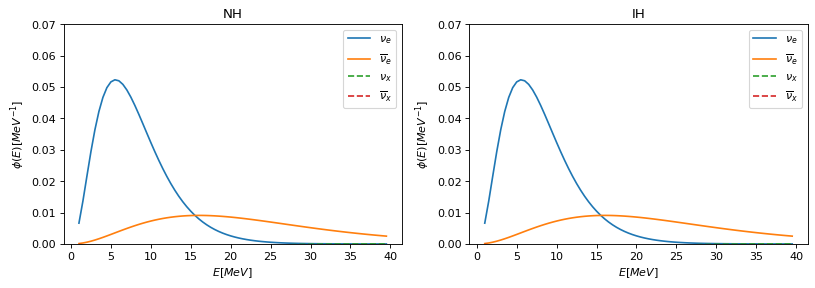

In [ ]:
t_step=10
t_f=len(t_vec)

fig = plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots()
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_xlabel(r'$E [MeV]$')
ax1.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
nu_NH, = ax1.plot(E_vec,nu3_NH[0],label=r'$\nu_e$')
antinu_NH, = ax1.plot(E_vec,antinu3_NH[0],label=r'$\overline{\nu}_e$')
nu_x_NH, = ax1.plot(E_vec,-1*np.asarray(nu3_NH[0]), linestyle="--",label=r'$\nu_x$')
antinu_x_NH, = ax1.plot(E_vec,-1*np.asarray(antinu3_NH[0]), linestyle="--",label=r'$\overline{\nu}_x$')
ax1.set_ylim(0,0.07)
ax1.set_title("NH")
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_xlabel(r'$E [MeV]$')
ax2.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
nu_IH, = ax2.plot(E_vec,nu3_IH[0],label=r'$\nu_e$')
antinu_IH, = ax2.plot(E_vec,antinu3_IH[0],label=r'$\overline{\nu}_e$')
nu_x_IH, = ax2.plot(E_vec,-1*np.asarray(nu3_IH[0]), linestyle="--",label=r'$\nu_x$')
antinu_x_IH, = ax2.plot(E_vec,-1*np.asarray(antinu3_IH[0]), linestyle="--",label=r'$\overline{\nu}_x$')
ax2.set_ylim(0,0.07)
ax2.set_title("IH")
ax2.legend(loc='upper right')



def update(t_i):
    nu_NH.set_data(E_vec,nu3_NH[t_i])
    antinu_NH.set_data(E_vec,antinu3_NH[t_i])
    nu_IH.set_data(E_vec,nu3_IH[t_i])
    antinu_IH.set_data(E_vec,antinu3_IH[t_i])
    nu_x_NH.set_data(E_vec,-1*np.asarray(nu3_NH[t_i]))
    antinu_x_NH.set_data(E_vec,-1*np.asarray(antinu3_NH[t_i]))
    nu_x_IH.set_data(E_vec,-1*np.asarray(nu3_IH[t_i]))
    antinu_x_IH.set_data(E_vec,-1*np.asarray(antinu3_IH[t_i]))
    #ax.set_title('Spectrum (10kpc)- t=%f s'%(t_data[0][t_i]))
    #max=np.amax(phi_aux)
    #ax.set_ylim(0, max)
    #print(max)

ani = FuncAnimation(fig, update, frames=np.arange(0,t_f,t_step), interval=100)

In [ ]:
HTML(ani.to_html5_video())

# 3.$\mu=0$ 

In [ ]:
G_F=1.1663787*10**(-23) #eV⁻² - Fermi Constant
delta_m2_31=2.5*10**(-3) #eV² - \Delta m²_31
#theta_31=np.arcsin(math.sqrt(2.18*10**-2)) #\theta_31
theta_31=10**(-1)#\theta_31
N_A=6.02*10**(23) #Avogadro constant

#Calculate the effective mass squared difference in matter
def delta_m2_eff(delta_m2,theta,Acc):
  delta = math.sqrt((delta_m2*np.cos(2*theta)-Acc)**2+(delta_m2*np.sin(2*theta))**2)
  return delta

#Calculate the effective mixing angle in matter
def theta_eff(delta_m2,theta,Acc):
  theta_eff=(1/2)*math.atan2(1,1/((math.tan(2*theta))/(1-(Acc/(delta_m2*np.cos(2*theta))))))
  return theta_eff

#Calculate the matter "Potential" - Acc=2EV_cc
def Acc(N_e,E):
  A = 2*math.sqrt(2)*E*G_F*N_e
  return A

def B_vec(E):
  E=E*10**6 #From MeV to eV
  B=delta_m2_31/(2*E)
  B1=B*np.sin(2*theta_31)
  B2=0
  B3=B*np.cos(2*theta_31)
  return B,B1,B2,B3

In [ ]:
def f_nu_antinu_coupled_mu_0(y, time, params):
    B1, B2, B3= params  # unpack parameters
    mu=mu_supernova_vec(time)
    derivs=[]
    nu1, nu2, nu3, antinu1, antinu2, antinu3 = [],[],[],[],[],[]
    for i in range(int(len(y)/6)):
      nu1.append(y[(i*6)])
      nu2.append(y[(i*6)+1])
      nu3.append(y[(i*6)+2]) 
      antinu1.append(y[(i*6)+3]) 
      antinu2.append(y[(i*6)+4]) 
      antinu3.append(y[(i*6)+5])    # unpack current values of y

    # list of dy/dt=f functions
    for i in range(len(nu1)):
      derivs.append(nu2[i]*B3[i]-nu3[i]*B2[i])  
      derivs.append(nu3[i]*B1[i]-nu1[i]*B3[i])
      derivs.append(nu1[i]*B2[i]-nu2[i]*B1[i])
      derivs.append(-1*(antinu2[i]*B3[i]-antinu3[i]*B2[i]))      
      derivs.append(-1*(antinu3[i]*B1[i]-antinu1[i]*B3[i]))
      derivs.append(-1*(antinu1[i]*B2[i]-antinu2[i]*B1[i]))      
    return derivs

In [ ]:
t_max = 10*(2*np.pi/min(B_vec(E_vec)[0])) #eV⁻¹
t_step = (2*np.pi/max(B_vec(E_vec)[0]))/20 #eV⁻¹
t_vec = np.arange(0., 500*t_step , t_step) #eV⁻¹

# Parameters for ODE solver
B1,B2,B3=[],[],[]
for E in E_vec:      
  B1.append(B_vec(E)[1])
  B2.append(B_vec(E)[2])
  B3.append(B_vec(E)[3])


In [ ]:
psoln_mu_0_NH= odeint(f_nu_antinu_coupled_mu_0, y0, t_vec, args=(np.array([B1, B2, B3]),))

In [ ]:
psoln_mu_0_IH= odeint(f_nu_antinu_coupled_mu_0, y0, t_vec, args=(np.array([-1*np.asarray(B1),-1*np.asarray(B2),-1*np.asarray(B3)]),))

In [ ]:
#psoln_trans=np.transpose(psoln,(1,0))
nu1_NH, nu2_NH, nu3_NH, antinu1_NH, antinu2_NH, antinu3_NH = [],[],[],[],[],[]
for j in range(len(psoln_mu_0_NH)):
  nu1_NH.append([])
  nu2_NH.append([])
  nu3_NH.append([])
  antinu1_NH.append([])
  antinu2_NH.append([]) 
  antinu3_NH.append([])
  for i in range(len(E_vec)):
    nu1_NH[j].append(psoln_mu_0_NH[j][(i*6)])
    nu2_NH[j].append(psoln_mu_0_NH[j][(i*6)+1])
    nu3_NH[j].append(psoln_mu_0_NH[j][(i*6)+2])
    antinu1_NH[j].append(psoln_mu_0_NH[j][(i*6)+3])
    antinu2_NH[j].append(psoln_mu_0_NH[j][(i*6)+4]) 
    antinu3_NH[j].append(psoln_mu_0_NH[j][(i*6)+5])

nu1_IH, nu2_IH, nu3_IH, antinu1_IH, antinu2_IH, antinu3_IH = [],[],[],[],[],[]
for j in range(len(psoln_mu_0_IH)):
  nu1_IH.append([])
  nu2_IH.append([])
  nu3_IH.append([])
  antinu1_IH.append([])
  antinu2_IH.append([]) 
  antinu3_IH.append([])
  for i in range(len(E_vec)):
    nu1_IH[j].append(psoln_mu_0_IH[j][(i*6)])
    nu2_IH[j].append(psoln_mu_0_IH[j][(i*6)+1])
    nu3_IH[j].append(psoln_mu_0_IH[j][(i*6)+2])
    antinu1_IH[j].append(psoln_mu_0_IH[j][(i*6)+3])
    antinu2_IH[j].append(psoln_mu_0_IH[j][(i*6)+4]) 
    antinu3_IH[j].append(psoln_mu_0_IH[j][(i*6)+5])

Text(0.5, 0, 'E [MeV]')

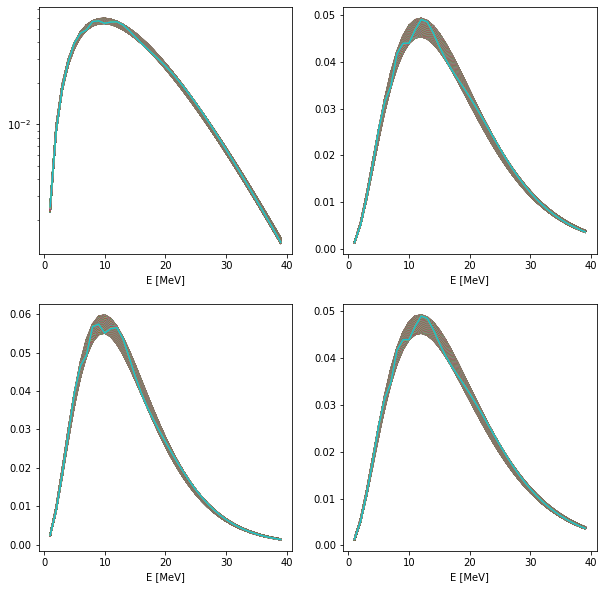

In [ ]:
# Plot results
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
for i in range(len(psoln_mu_0_NH)):
  plt.plot(E_vec, np.array(nu3_NH[i]))
#plt.ylim(0.0,0.07)
plt.yscale('log')
plt.xlabel('E [MeV]')

plt.subplot(2,2,2)
for i in range(len(psoln_mu_0_NH)):
  plt.plot(E_vec,(antinu3_NH[i]))
#plt.ylim(0.0,0.07)
plt.xlabel('E [MeV]')
#plt.legend(loc='lower right')

plt.subplot(2,2,3)
for i in range(len(psoln_mu_0_IH)):
  plt.plot(E_vec, np.array(nu3_IH[i]))
#plt.ylim(0.0,0.07)
plt.xlabel('E [MeV]')

plt.subplot(2,2,4)
for i in range(len(psoln_mu_0_IH)):
  plt.plot(E_vec,(antinu3_IH[i]))
#plt.ylim(0.0,0.07)
plt.xlabel('E [MeV]')
#plt.legend(loc='lower right')

In [ ]:
print(min(B_vec(E_vec)[0]))
print(max(B_vec(E_vec)[0]))

3.205128205128205e-11
1.25e-09


In [ ]:
print("E min:",E_vec[0],"MeV, B:",B_vec(E_vec[0])[0],"eV")
print("E max:",E_vec[-1],"MeV, B:",B_vec(E_vec[-1])[0],"eV")

E min: 1 MeV, B: 1.25e-09 eV
E max: 39 MeV, B: 3.205128205128205e-11 eV


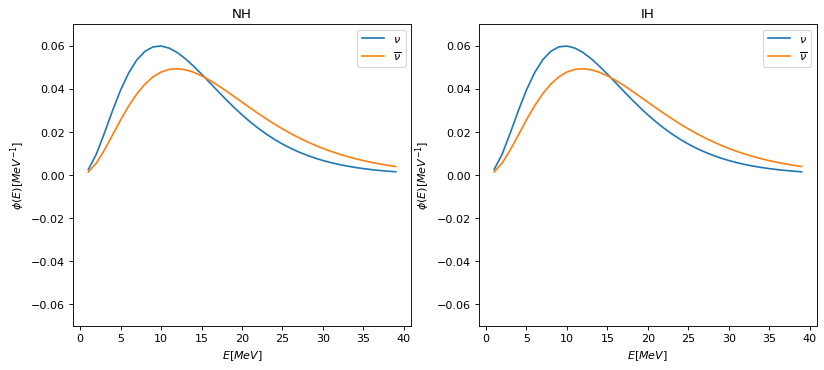

In [ ]:
from matplotlib.animation import FuncAnimation
t_step=10
t_f=len(t_vec)

fig = plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel(r'$E [MeV]$')
ax1.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
nu_NH, = ax1.plot(E_vec,nu3_NH[0],label=r'$\nu$')
antinu_NH, = ax1.plot(E_vec,antinu3_NH[0],label=r'$\overline{\nu}$')
ax1.set_ylim(-0.07,0.07)
#ax.set_yscale('log')
ax1.set_title("NH")
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel(r'$E [MeV]$')
ax2.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
nu_IH, = ax2.plot(E_vec,nu3_IH[0],label=r'$\nu$')
antinu_IH, = ax2.plot(E_vec,antinu3_IH[0],label=r'$\overline{\nu}$')
ax2.set_ylim(-0.07,0.07)
#ax.set_yscale('log')
ax2.set_title("IH")
ax2.legend(loc='upper right')

def update(t_i):
    nu_NH.set_data(E_vec,nu3_NH[t_i])
    antinu_NH.set_data(E_vec,antinu3_NH[t_i])
    nu_IH.set_data(E_vec,nu3_IH[t_i])
    antinu_IH.set_data(E_vec,antinu3_IH[t_i])
    #ax.set_title('Spectrum (10kpc)- t=%f s'%(t_data[0][t_i]))
    #max=np.amax(phi_aux)
    #ax.set_ylim(0, max)
    #print(max)

ani = FuncAnimation(fig, update, frames=np.arange(0,t_f,t_step), interval=100)

In [ ]:
HTML(ani.to_html5_video())

# 4.Generic Implementation

Here, we generalize the code implementation to consider bipolar systems formed by any flavor (in 2 families) with neutrinos and anti-neutrinos

## 4.1 - First Implementation


In [ ]:
G_F=1.1663787*10**(-23) #eV⁻² - Fermi Constant
delta_m2_31=2.5*10**(-3) #eV² - \Delta m²_31
#theta_31=np.arcsin(math.sqrt(2.18*10**-2)) #\theta_31
theta_31=10**(-4)#\theta_31
N_A=6.02*10**(23) #Avogadro constant
from_eV_to_1_over_m=8.065543937*10**5
from_eV_to_1_over_km=from_eV_to_1_over_m*10**(3)

#Calculate the effective mass squared difference in matter
def delta_m2_eff(delta_m2,theta,Acc):
  delta = math.sqrt((delta_m2*np.cos(2*theta)-Acc)**2+(delta_m2*np.sin(2*theta))**2)
  return delta

#Calculate the effective mixing angle in matter
def theta_eff(delta_m2,theta,Acc):
  theta_eff=(1/2)*math.atan2(1,1/((math.tan(2*theta))/(1-(Acc/(delta_m2*np.cos(2*theta))))))
  return theta_eff

#Calculate the matter "Potential" - Acc=2EV_cc
def Acc(N_e,E):
  A = 2*math.sqrt(2)*E*G_F*N_e
  return A

def B_vec(E):
  E=E*10**6 #From MeV to eV
  B=delta_m2_31/(2*E)
  B1=-1*B*np.sin(2*theta_31)
  B2=0
  B3=B*np.cos(2*theta_31)
  return B,B1,B2,B3

### Supernova Spectrum

In [ ]:
def phi(E,E_0,alpha):
  N=((alpha+1)**(alpha+1))/(E_0*gamma(alpha+1))
  R=N*((E/E_0)**alpha)*math.exp((-1)*(alpha+1)*E/E_0)
  return R
phi_vec= np.vectorize(phi)

print("Testing the espectrum normalization:",integrate.quad(lambda E: phi(E,14,2.3), 0, 100)[0])

#Neutrino potential
def mu_supernova(r,mu_0): # r in eV⁻¹
  R_0=4*10**4#m
  R_0= R_0*(8*10**5) #eV⁻¹
  if r<R_0:
    return mu_0
  return mu_0*(R_0/r)**4
mu_supernova_vec=np.vectorize(mu_supernova)

Testing the espectrum normalization: 0.9999999658440586


### Initial Conditions

In [ ]:
#Energy
E_step=0.5
E_vec=np.arange(1,40,E_step)

#Initial spectrum
nu_types=['nu_e']
E_0=[8,23] #Mean energy in MeV
Amplitude=[1,0.5]

y0=[] #Initial state
B,B1,B2,B3=[],[],[],[]

for i in range(len(E_vec)): 
  B_aux,B1_aux,B2_aux,B3_aux= B_vec(E_vec[i]) 
  B.append(B_aux)
  B1.append(B1_aux)
  B2.append(B2_aux)
  B3.append(B3_aux)

  for j in range(len(nu_types)):
    #nu
    nu_spec=Amplitude[j]*phi_vec(E_vec[i],E_0[j],2.3)*E_step
    y0.append(0)
    y0.append(0)
    y0.append(nu_spec)
    #nubar
    nu_spec=Amplitude[j+1]*phi_vec(E_vec[i],E_0[j+1],2.3)*E_step
    y0.append(0)
    y0.append(0)
    y0.append(nu_spec)

#time
t_bins=1000
t_max = 4*(2*np.pi/min(B_vec(E_vec)[0])) #eV⁻¹
t_step = (2*np.pi/max(B_vec(E_vec)[0]))/20 #eV⁻¹
t_vec = np.arange(0., t_bins*t_step , t_step) #eV⁻¹

#mu
mu_0=(10)*max(B_vec(E_vec)[0])

In [ ]:
print("Omega max:",max(B_vec(E_vec)[0])*from_eV_to_1_over_km,"km⁻¹")
print("Distance step:",t_step/from_eV_to_1_over_km,"km")
print("--------------------------------------------------------")
print("Omega min:",min(B_vec(E_vec)[0])*from_eV_to_1_over_km,"km⁻¹")
print("Distance max:",t_max/from_eV_to_1_over_km,"km")

Omega max: 1.008192992125 km⁻¹
Distance step: 0.3116062775806604 km
--------------------------------------------------------
Omega min: 0.025523873218354427 km⁻¹
Distance max: 984.6758371548868 km


### System of Equations

$$\vdots$$

$$ \frac{d}{dt}P_{\nu_\alpha,(j+0)}(E_j) = \epsilon_{0mn} P_{\nu_\alpha,(j+m)}(E_j)B_n(E_j) + \epsilon_{0mn}  P_{\nu_\alpha,(j+m)}(E_j)\sum_k [P_{\nu_\alpha,(k+n)}(E_j)-\overline{P}_{\nu_\alpha,(k+n)}(E_j)]$$

$$ \frac{d}{dt}P_{\nu_\alpha,(j+1)}(E_j) =  \epsilon_{1mn} P_{\nu_\alpha,(j+m)}(E_j)B_n(E_j) + \epsilon_{1mn}  P_{\nu_\alpha,(j+m)}(E_j) \sum_k [P_{\nu_\alpha,(k+n)}(E_j)-\overline{P}_{\nu_\alpha,(k+n)}(E_j)]$$

$$ \frac{d}{dt}P_{\nu_\alpha,(j+2)}(E_j)= \epsilon_{2mn} P_{\nu_\alpha,(j+m)}(E_j)B_n(E_j) + \epsilon_{2mn}  P_{\nu_\alpha,(j+m)}(E_j)\sum_k [P_{\nu_\alpha,(k+n)}(E_j)-\overline{P}_{\nu_\alpha,(k+n)}(E_j)]$$

$$ \frac{d}{dt}\overline{P}_{\overline{\nu}_\alpha,(j+0)}(E_j) = \epsilon_{0mn} \overline{P}_{\nu_\alpha,(j+m)}(E_j)B_n(E_j) + \epsilon_{0mn}  \overline{P}_{\nu_\alpha,(j+m)}(E_j)\sum_k [P_{\nu_\alpha,(k+n)}(E_j)-\overline{P}_{\nu_\alpha,(k+n)}(E_j)] $$

$$ \frac{d}{dt}\overline{P}_{\overline{\nu}_\alpha,(j+1)}(E_j) = \epsilon_{1mn} \overline{P}_{\nu_\alpha,(j+m)}(E_j)B_n(E_j) + \epsilon_{1mn} \sum_k \overline{P}_{\nu_\alpha,(j+m)}(E_j)[P_{\nu_\alpha,(k+n)}(E_j)-\overline{P}_{\nu_\alpha,(k+n)}(E_j)] $$

$$ \frac{d}{dt}\overline{P}_{\overline{\nu}_\alpha,(j+2)}(E_j) = \epsilon_{2mn} \overline{P}_{\nu_\alpha,(j+m)}(E_j)B_n(E_j) + \epsilon_{2mn}  \overline{P}_{\nu_\alpha,(j+m)}(E_j)\sum_k [P_{\nu_\alpha,(k+n)}(E_j)-\overline{P}_{\nu_\alpha,(k+n)}(E_j)] $$

$$\vdots$$



In [ ]:
def f_nu_antinu_coupled_mu_var(y, time, params):
    B= params  # unpack parameters
    mu=mu_supernova_vec(time,mu_0)
    derivs=[]
    nu, nubar = [],[]
    #Information to decompose the y array in each P_i
    space_dim=3
    num_of_nu_flavors=len(nu_types)
    num_diff_nu_compnents=2*space_dim*num_of_nu_flavors # 2(nu+nu_bar)*space dimention*nu_types
    num_E_bins=int(len(y)/(num_diff_nu_compnents))

    #Creating [3components][Nu_types] arrays
    for k in range(space_dim):
      nu.append([])
      nubar.append([])
      for j in range(num_of_nu_flavors):
          nu[k].append([])
          nubar[k].append([])

    #Filling [Nu_types][3components] arrays with [Energy bin]
    for i in range(num_E_bins):
      for j in range(num_of_nu_flavors):
        for k in range(space_dim):
          nu[k][j].append(y[(i*num_diff_nu_compnents)+k+j*2*space_dim])
          nubar[k][j].append(y[(i*num_diff_nu_compnents)+(k+3)+j*2*space_dim])
    
    #Summed nu and nubar components
    nu_sum, nubar_sum=[],[]
    for k in range(space_dim):
      nu_sum.append(sum(map(sum, nu[k])))
      nubar_sum.append(sum(map(sum, nubar[k])))

    # list of dy/dt=f functions
    for i in range(num_E_bins):
      for j in range(num_of_nu_flavors):
        for k in range(space_dim):
          #nu 
          derivs.append(nu[(k+1)%3][j][i]*B[(k+2)%3][i]-nu[(k+2)%3][j][i]*B[(k+1)%3][i]-
                      mu*(nu[(k+1)%3][j][i]*(nu_sum[(k+2)%3]-nubar_sum[(k+2)%3])-
                          nu[(k+2)%3][j][i]*(nu_sum[(k+1)%3]-nubar_sum[(k+1)%3])))
        for k in range(space_dim):
          #nubar
          derivs.append(-1*(nubar[(k+1)%3][j][i]*B[(k+2)%3][i]-nubar[(k+2)%3][j][i]*B[(k+1)%3][i])-
                      mu*(nubar[(k+1)%3][j][i]*(nu_sum[(k+2)%3]-nubar_sum[(k+2)%3])-
                          nubar[(k+2)%3][j][i]*(nu_sum[(k+1)%3]-nubar_sum[(k+1)%3])))
    return derivs

def read_output(psoln):
  space_dim=3
  num_of_nus=len(nu_types)  
  print("Num of nus",num_of_nus)
  num_E_bins=int(len(psoln[0])/(2*space_dim*num_of_nus))
  print("Num of E bins",num_E_bins)

  nu,nubar=[],[]
  for l in range(space_dim):
    nu.append([])
    nubar.append([])
    for k in range(num_of_nus):
      nu[l].append([])
      nubar[l].append([])
      for j in range(len(psoln)):
        nu[l][k].append([])
        nubar[l][k].append([])
        for i in range(num_E_bins):
          nu[l][k][j].append(psoln[j][(i*2*space_dim*num_of_nus)+l+k*2*space_dim])
          nubar[l][k][j].append(psoln[j][(i*2*space_dim*num_of_nus)+l+3+k*2*space_dim])

  return nu[0], nu[1], nu[2], nubar[0], nubar[1], nubar[2]

def compute_sum(nu1, nu2, nu3):
  nu_sum1, nu_sum2, nu_sum3 = [],[],[]
  for i in range(len(nu_sum1)):
    nu_sum1.append(sum(nu1[i]))
    nu_sum2.append(sum(nu2[i]))
    nu_sum3.append(sum(nu3[i]))
  return nu_sum1, nu_sum2, nu_sum3

### Solutions

In [ ]:
psoln_NH= odeint(f_nu_antinu_coupled_mu_var, y0, t_vec, args=(np.array([B1, B2, B3]),))

KeyboardInterrupt: ignored

In [ ]:
psoln_IH= odeint(f_nu_antinu_coupled_mu_var, y0, t_vec, args=(np.array([-1*np.asarray(B1),-1*np.asarray(B2),-1*np.asarray(B3)]),))

In [ ]:
#NH
nu1_NH, nu2_NH, nu3_NH, antinu1_NH, antinu2_NH, antinu3_NH= read_output(psoln_NH)
nu_sum1_NH, nu_sum2_NH, nu_sum3_NH=compute_sum(nu1_NH, nu2_NH, nu3_NH)
antinu_sum1_NH, antinu_sum2_NH, antinu_sum3_NH=compute_sum(antinu1_NH, antinu2_NH, antinu3_NH)
#IH
nu1_IH, nu2_IH, nu3_IH, antinu1_IH, antinu2_IH, antinu3_IH= read_output(psoln_IH)
nu_sum1_IH, nu_sum2_IH, nu_sum3_IH=compute_sum(nu1_IH, nu2_IH, nu3_IH)
antinu_sum1_IH, antinu_sum2_IH, antinu_sum3_IH=compute_sum(antinu1_IH, antinu2_IH, antinu3_IH)

Num of nus 1
Num of nus 78
Num of nus 1
Num of nus 78


### Animation

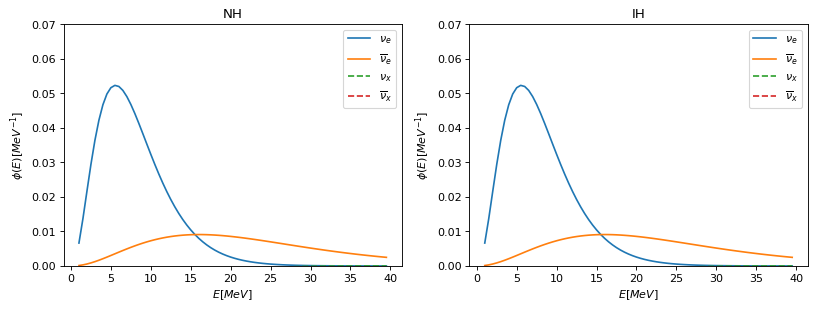

In [ ]:
t_step=10
t_f=len(t_vec)

fig = plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel(r'$E [MeV]$')
ax1.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
nu_NH, = ax1.plot(E_vec,nu3_NH[0][0],label=r'$\nu_e$')
antinu_NH, = ax1.plot(E_vec,antinu3_NH[0][0],label=r'$\overline{\nu}_e$')
nu_x_NH, = ax1.plot(E_vec,-1*np.asarray(nu3_NH[0][0]), linestyle="--",label=r'$\nu_x$')
antinu_x_NH, = ax1.plot(E_vec,-1*np.asarray(antinu3_NH[0][0]), linestyle="--",label=r'$\overline{\nu}_x$')
ax1.set_ylim(0,0.07)
ax1.set_title("NH")
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel(r'$E [MeV]$')
ax2.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
nu_IH, = ax2.plot(E_vec,nu3_IH[0][0],label=r'$\nu_e$')
antinu_IH, = ax2.plot(E_vec,antinu3_IH[0][0],label=r'$\overline{\nu}_e$')
nu_x_IH, = ax2.plot(E_vec,-1*np.asarray(nu3_IH[0][0]), linestyle="--",label=r'$\nu_x$')
antinu_x_IH, = ax2.plot(E_vec,-1*np.asarray(antinu3_IH[0][0]), linestyle="--",label=r'$\overline{\nu}_x$')
ax2.set_ylim(0,0.07)
ax2.set_title("IH")
ax2.legend(loc='upper right')

def update(t_i):
    nu_NH.set_data(E_vec,nu3_NH[0][t_i])
    antinu_NH.set_data(E_vec,antinu3_NH[0][t_i])
    nu_IH.set_data(E_vec,nu3_IH[0][t_i])
    antinu_IH.set_data(E_vec,antinu3_IH[0][t_i])
    nu_x_NH.set_data(E_vec,-1*np.asarray(nu3_NH[0][t_i]))
    antinu_x_NH.set_data(E_vec,-1*np.asarray(antinu3_NH[0][t_i]))
    nu_x_IH.set_data(E_vec,-1*np.asarray(nu3_IH[0][t_i]))
    antinu_x_IH.set_data(E_vec,-1*np.asarray(antinu3_IH[0][t_i]))
    #ax.set_title('Spectrum (10kpc)- t=%f s'%(t_data[0][t_i]))
    #max=np.amax(phi_aux)
    #ax.set_ylim(0, max)
    #print(max)

ani = FuncAnimation(fig, update, frames=np.arange(0,t_f,t_step), interval=100)

In [ ]:
HTML(ani.to_html5_video())

In [ ]:
print(len(nu1_NH))
print(len(nu1_NH[0]))
print(len(E_vec))
print(E_vec[25])

1000
78
78
13.5


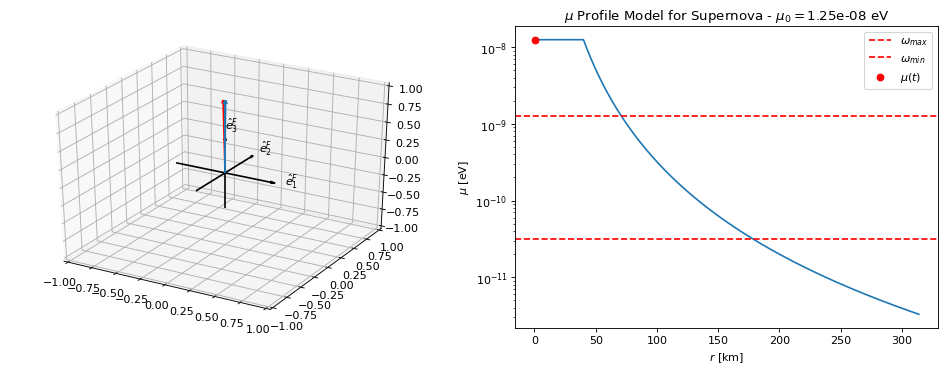

In [ ]:
E_i=25
t_step=5
t_f=len(t_vec)

fig = plt.figure(figsize=(15,5), dpi= 80, facecolor='w', edgecolor='k')
#fig = plt.figure()
ax1 = fig.add_subplot(1,2,1,projection='3d')

quiver_B = ax1.quiver(0, 0, 0, B1[E_i], B2[E_i], B3[E_i], arrow_length_ratio=0.05,color='r',normalize=True)

quiver_P=[]
E_i=[0,10,25,30,40,50]
for i in range(len(E_i)):
  P1,P2,P3= nu1_IH[0][E_i[i]],nu2_IH[0][E_i[i]], nu3_IH[0][E_i[i]]
  P=np.sqrt(P1**2 + P2**2 + P3**2)
  quiver_P_aux=ax1.quiver(0, 0, 0,P1/P,P2/P,P3/P, arrow_length_ratio=0.05)
  quiver_P.append(quiver_P_aux)

ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_zlim(-1, 1)
ax1.quiver(-0.5, 0, 0, 1, 0, 0, arrow_length_ratio=0.05,color='k')
ax1.text(0.6,0,0, r"$\hat{e}^F_1$", color='k')
ax1.quiver(0, -0.5, 0, 0, 1, 0, arrow_length_ratio=0.05,color='k')
ax1.text(0,0.6,0, r"$\hat{e}^F_2$", color='k')
ax1.quiver(0, 0, -0.5, 0, 0, 1, arrow_length_ratio=0.05,color='k')
ax1.text(0,0,0.6, r"$\hat{e}^F_3$", color='k')
#ax1.set_title(r'Polarization Vectors - $E_\nu=%.1f$ MeV'%(E_vec[E_i]))

ax2 = fig.add_subplot(1, 2, 2)
#ax2.set_ylim(mu_supernova_vec(t_vec[-1],mu_0), mu_supernova_vec(t_vec[0],mu_0)*1.2)
#ax2.set_xlim(0, t_vec[-1]/(8*10**5)*10**-3)
ax2.plot(t_vec/(8*10**5)*10**-3,mu_supernova_vec(t_vec,mu_0))
ax2.axhline(y=max(B_vec(E_vec)[0]), color="red", linestyle="--", label=r'$\omega_{max}$')
ax2.axhline(y=min(B_vec(E_vec)[0]), color="red", linestyle="--", label=r'$\omega_{min}$')
ax2.set_xlabel(r'$r$ [km]')
ax2.set_ylabel(r'$\mu$ [eV]')
ax2.set_yscale('log')
ax2.set_title(r"$\mu$ Profile Model for Supernova - $\mu_0=$%.2e eV"%(mu_0))
#mu_plot, = ax2.plot([], [])
mu_point, = ax2.plot(t_vec[0]/(8*10**5)*10**-3,mu_supernova_vec(t_vec[0],mu_0),'r.',markersize=12,label=r'$\mu(t)$')
ax2.legend()

def update(t_i):
    #3D plot
    #P vector
    global quiver_P
    for i in range(len(E_i)):
      quiver_P[i].remove()
      P1,P2,P3= nu1_IH[t_i][E_i[i]],nu2_IH[t_i][E_i[i]], nu3_IH[t_i][E_i[i]]
      P=np.sqrt(P1**2 + P2**2 + P3**2)
      quiver_P[i] = ax1.quiver(0, 0, 0,P1/P,P2/P,P3/P, arrow_length_ratio=0.05)

    #mu plot
    #mu_plot.set_data(t_vec[0:t_i]/(8*10**5)*10**-3,mu_supernova_vec(t_vec[0:t_i],mu_0))
    mu_point.set_data(t_vec[t_i]/(8*10**5)*10**-3,mu_supernova_vec(t_vec[t_i],mu_0))

ani = FuncAnimation(fig, update, frames=np.arange(1,t_f,t_step), interval=100)

In [ ]:
HTML(ani.to_html5_video())



---



## 4.2 - ($\nu_e,\overline{\nu}_e,\nu_x, \overline{\nu}_x$)


In [ ]:
#Energy
E_step=0.1
E_vec=np.arange(1,50,E_step)

#Initial spectrum
nu_types=['nu_e','nu_x']
E_0=[10,15,24,24] #Mean energy in MeV
Amplitude=[1,1,1,1]

y0=[] #Initial state
B1,B2,B3=[],[],[]

flavor=1

for i in range(len(E_vec)):      
  B1.append(B_vec(E_vec[i])[1])
  B2.append(B_vec(E_vec[i])[2])
  B3.append(B_vec(E_vec[i])[3])

  for j in range(len(nu_types)):
    if nu_types[j]=="nu_x":
      flavor=-1
    if nu_types[j]=="nu_e":
      flavor=1
    #nu
    nu_spec=Amplitude[len(nu_types)*j]*phi_vec(E_vec[i],E_0[len(nu_types)*j],2.3)*E_step
    y0.append(0)
    y0.append(0)
    y0.append(flavor*nu_spec)
    #nubar
    nu_spec=Amplitude[len(nu_types)*j+1]*phi_vec(E_vec[i],E_0[len(nu_types)*j+1],2.3)*E_step
    y0.append(0)
    y0.append(0)
    y0.append(flavor*nu_spec)

#time
t_bins=1000
t_max = 4*(2*np.pi/min(B_vec(E_vec)[0])) #eV⁻¹
t_step = (2*np.pi/max(B_vec(E_vec)[0]))/20 #eV⁻¹
t_vec = np.arange(0., t_bins*t_step , t_step) #eV⁻¹

#mu
mu_0=(10)*max(B_vec(E_vec)[0])

In [ ]:
psoln_nu_x_NH= odeint(f_nu_antinu_coupled_mu_var, y0, t_vec, args=(np.array([B1, B2, B3]),))

In [ ]:
psoln_nu_x_IH= odeint(f_nu_antinu_coupled_mu_var, y0, t_vec, args=(np.array([-1*np.asarray(B1),-1*np.asarray(B2),-1*np.asarray(B3)]),))

In [ ]:
def read_output(psoln):
  space_dim=3
  num_of_nus=len(nu_types)  
  print("Num of nus",num_of_nus)
  num_E_bins=int(len(psoln[0])/(2*space_dim*num_of_nus))
  print("Num of E bins",num_E_bins)

  nu,nubar=[],[]
  for l in range(space_dim):
    nu.append([])
    nubar.append([])
    for k in range(num_of_nus):
      nu[l].append([])
      nubar[l].append([])
      for j in range(len(psoln)):
        nu[l][k].append([])
        nubar[l][k].append([])
        for i in range(num_E_bins):
          nu[l][k][j].append(psoln[j][(i*2*space_dim*num_of_nus)+l+k*2*space_dim])
          nubar[l][k][j].append(psoln[j][(i*2*space_dim*num_of_nus)+l+3+k*2*space_dim])

  return nu, nubar #[Pauli Matrix][Nu_type][time][energy]

def read_flavor(nu, nubar):
  nu_e_time,nubar_e_time=[],[]
  nu_x_time,nubar_x_time=[],[]

  for l in range(len(nu_NH[0][0])): #time array length
      nu_e_time.append([])
      nubar_e_time.append([])
      nu_x_time.append([])
      nubar_x_time.append([])
      for i in range(len(nu_NH[0][0][0])): 
        #nu
        P3_x,P3_e=0,0
        if nu[2][0][l][i]>0:
          P3_e=P3_e+nu[2][0][l][i]
        else:
          P3_x=P3_x+nu[2][0][l][i]

        if nu[2][1][l][i]>0:
          P3_e=P3_e+nu[2][1][l][i]
        else:
          P3_x=P3_x+nu[2][1][l][i]

        nu_e_time[l].append(P3_e)
        nu_x_time[l].append(-1*P3_x)

        #nubar
        P3_x,P3_e=0,0
        if nubar[2][0][l][i]>0:
          P3_e=P3_e+nubar[2][0][l][i]
        else:
          P3_x=P3_x+nubar[2][0][l][i]

        if nubar[2][1][l][i]>0:
          P3_e=P3_e+nubar[2][1][l][i]
        else:
          P3_x=P3_x+nubar[2][1][l][i]

        nubar_e_time[l].append(P3_e)
        nubar_x_time[l].append(-1*P3_x)

  return   nu_e_time,nubar_e_time, nu_x_time,nubar_x_time

In [ ]:
#NH
nu_NH, nubar_NH= read_output(psoln_nu_x_NH)
nu_e_time_NH,nubar_e_time_NH, nu_x_time_NH,nubar_x_time_NH=read_flavor(nu_NH, nubar_NH)
#IH
nu_IH, nubar_IH= read_output(psoln_nu_x_IH)
nu_e_time_IH,nubar_e_time_IH, nu_x_time_IH,nubar_x_time_IH=read_flavor(nu_IH, nubar_IH)

Num of nus 2
Num of E bins 490
Num of nus 2
Num of E bins 490


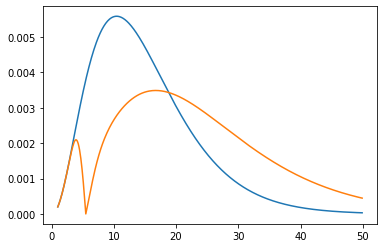

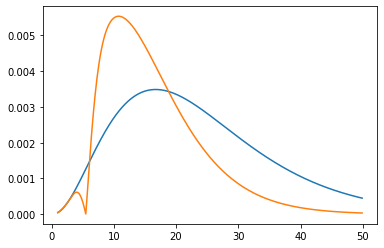

In [ ]:
plt.figure()
plt.plot(E_vec,nubar_e_time_IH[0])
plt.plot(E_vec,nubar_e_time_IH[500])

plt.figure()
plt.plot(E_vec,nubar_x_time_IH[0])
plt.plot(E_vec,nubar_x_time_IH[500])

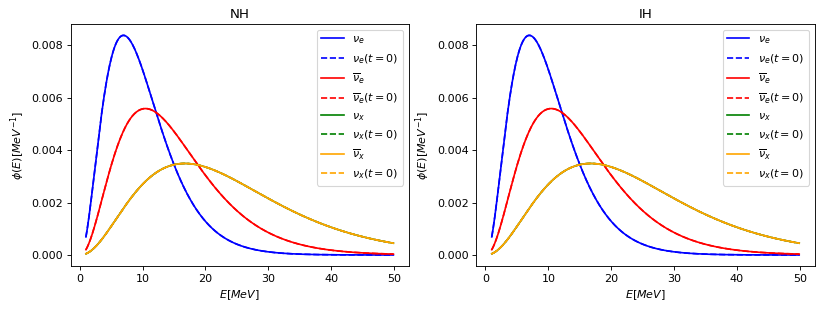

In [ ]:
t_step=10
t_f=len(t_vec)

fig = plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel(r'$E [MeV]$')
ax1.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
#nu_e
nu_NH_line, = ax1.plot(E_vec, nu_e_time_NH[0],color='b',label=r'$\nu_e$')
ax1.plot(E_vec, nu_e_time_NH[0],color='b', linestyle="--",label=r'$\nu_e(t=0)$')#Initial
antinu_NH_line, = ax1.plot(E_vec,nubar_e_time_NH[0],color='r',label=r'$\overline{\nu}_e$')
ax1.plot(E_vec, nubar_e_time_NH[0],color='r', linestyle="--",label=r'$\overline{\nu}_e(t=0)$')#Initial
#nu_x
nu_x_NH_line, = ax1.plot(E_vec,nu_e_time_NH[0],color='g',label=r'$\nu_x$')
ax1.plot(E_vec, nu_x_time_NH[0],color='g', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
antinu_x_NH_line, = ax1.plot(E_vec,nubar_x_time_NH[0],color='orange',label=r'$\overline{\nu}_x$')
ax1.plot(E_vec, nubar_x_time_NH[0],color='orange', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
#ax1.set_ylim(0,0.07)
ax1.set_title("NH")
ax1.legend(loc='upper right')

#IH
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel(r'$E [MeV]$')
ax2.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
#nu_e
nu_IH_line, = ax2.plot(E_vec, nu_e_time_IH[0],color='b',label=r'$\nu_e$')
ax2.plot(E_vec, nu_e_time_IH[0],color='b', linestyle="--",label=r'$\nu_e(t=0)$')#Initial
antinu_IH_line, = ax2.plot(E_vec,nubar_e_time_IH[0],color='r',label=r'$\overline{\nu}_e$')
ax2.plot(E_vec, nubar_e_time_IH[0],color='r', linestyle="--",label=r'$\overline{\nu}_e(t=0)$')#Initial
#nu_x
nu_x_IH_line, = ax2.plot(E_vec,nu_e_time_IH[0],color='g',label=r'$\nu_x$')
ax2.plot(E_vec, nu_x_time_IH[0],color='g', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
antinu_x_IH_line, = ax2.plot(E_vec,nubar_x_time_IH[0],color='orange',label=r'$\overline{\nu}_x$')
ax2.plot(E_vec, nubar_x_time_IH[0],color='orange', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
#ax2.set_ylim(0,0.07)
ax2.set_title("IH")
ax2.legend(loc='upper right')

def update(t_i):
    #NH
    nu_NH_line.set_data(E_vec,nu_e_time_NH[t_i])
    antinu_NH_line.set_data(E_vec,nubar_e_time_NH[t_i])
    nu_x_NH_line.set_data(E_vec,nu_x_time_NH[t_i])
    antinu_x_NH_line.set_data(E_vec,nubar_x_time_NH[t_i])
    #IH
    nu_IH_line.set_data(E_vec,nu_e_time_IH[t_i])
    antinu_IH_line.set_data(E_vec,nubar_e_time_IH[t_i])
    nu_x_IH_line.set_data(E_vec,nu_x_time_IH[t_i])
    antinu_x_IH_line.set_data(E_vec,nubar_x_time_IH[t_i])

    #ax.set_title('Spectrum (10kpc)- t=%f s'%(t_data[0][t_i]))
    #max=np.amax(phi_aux)
    #ax.set_ylim(0, max)
    #print(max)

ani = FuncAnimation(fig, update, frames=np.arange(0,t_f,t_step), interval=100)


In [ ]:
HTML(ani.to_html5_video())

**Função Genérica**

O que eu gostaria: função que me retorna os fluxos em função do tempo dando 

* mass_ord
* astro_param=E_0,E_tot (nu_e, nubar_e,nu_x, nubar_x)
* Num of time bins
* E_i,E_f 

## 4.3 - ($\nu_e,\nu_x$)


In [ ]:
#Energy
E_step=0.1
E_vec=np.arange(1,50,E_step)

#Initial spectrum
nu_types=['nu_e','nu_x']
E_0=[10,15,24,24] #Mean energy in MeV
Amplitude=[1,0,1,0]

y0=[] #Initial state
B1,B2,B3=[],[],[]

flavor=1

for i in range(len(E_vec)):      
  B1.append(B_vec(E_vec[i])[1])
  B2.append(B_vec(E_vec[i])[2])
  B3.append(B_vec(E_vec[i])[3])

  for j in range(len(nu_types)):
    if nu_types[j]=="nu_x":
      flavor=-1
    if nu_types[j]=="nu_e":
      flavor=1
    #nu
    nu_spec=Amplitude[len(nu_types)*j]*phi_vec(E_vec[i],E_0[len(nu_types)*j],2.3)*E_step
    y0.append(0)
    y0.append(0)
    y0.append(flavor*nu_spec)
    #nubar
    nu_spec=Amplitude[len(nu_types)*j+1]*phi_vec(E_vec[i],E_0[len(nu_types)*j+1],2.3)*E_step
    y0.append(0)
    y0.append(0)
    y0.append(flavor*nu_spec)

#time
t_bins=1000
t_max = 4*(2*np.pi/min(B_vec(E_vec)[0])) #eV⁻¹
t_step = (2*np.pi/max(B_vec(E_vec)[0]))/20 #eV⁻¹
t_vec = np.arange(0., t_bins*t_step , t_step) #eV⁻¹

#mu
mu_0=(10)*max(B_vec(E_vec)[0])

In [ ]:
psoln_nu_x_NH= odeint(f_nu_antinu_coupled_mu_var, y0, t_vec, args=(np.array([B1, B2, B3]),))

KeyboardInterrupt: ignored

In [ ]:
psoln_nu_x_IH= odeint(f_nu_antinu_coupled_mu_var, y0, t_vec, args=(np.array([-1*np.asarray(B1),-1*np.asarray(B2),-1*np.asarray(B3)]),))

In [ ]:
#NH
nu_NH, nubar_NH= read_output(psoln_nu_x_NH)
nu_e_time_NH,nubar_e_time_NH, nu_x_time_NH,nubar_x_time_NH=read_flavor(nu_NH, nubar_NH)
#IH
nu_IH, nubar_IH= read_output(psoln_nu_x_IH)
nu_e_time_IH,nubar_e_time_IH, nu_x_time_IH,nubar_x_time_IH=read_flavor(nu_IH, nubar_IH)

Num of nus 2
Num of E bins 490
Num of nus 2
Num of E bins 490


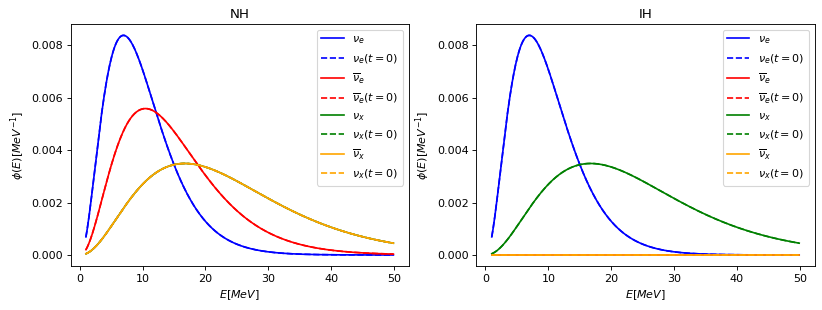

In [ ]:
t_step=10
t_f=len(t_vec)

fig = plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel(r'$E [MeV]$')
ax1.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
#nu_e
nu_NH_line, = ax1.plot(E_vec, nu_e_time_NH[0],color='b',label=r'$\nu_e$')
ax1.plot(E_vec, nu_e_time_NH[0],color='b', linestyle="--",label=r'$\nu_e(t=0)$')#Initial
antinu_NH_line, = ax1.plot(E_vec,nubar_e_time_NH[0],color='r',label=r'$\overline{\nu}_e$')
ax1.plot(E_vec, nubar_e_time_NH[0],color='r', linestyle="--",label=r'$\overline{\nu}_e(t=0)$')#Initial
#nu_x
nu_x_NH_line, = ax1.plot(E_vec,nu_e_time_NH[0],color='g',label=r'$\nu_x$')
ax1.plot(E_vec, nu_x_time_NH[0],color='g', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
antinu_x_NH_line, = ax1.plot(E_vec,nubar_x_time_NH[0],color='orange',label=r'$\overline{\nu}_x$')
ax1.plot(E_vec, nubar_x_time_NH[0],color='orange', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
#ax1.set_ylim(0,0.07)
ax1.set_title("NH")
ax1.legend(loc='upper right')

#IH
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel(r'$E [MeV]$')
ax2.set_ylabel(r'$\phi(E) [MeV^{-1}]$')
#nu_e
nu_IH_line, = ax2.plot(E_vec, nu_e_time_IH[0],color='b',label=r'$\nu_e$')
ax2.plot(E_vec, nu_e_time_IH[0],color='b', linestyle="--",label=r'$\nu_e(t=0)$')#Initial
antinu_IH_line, = ax2.plot(E_vec,nubar_e_time_IH[0],color='r',label=r'$\overline{\nu}_e$')
ax2.plot(E_vec, nubar_e_time_IH[0],color='r', linestyle="--",label=r'$\overline{\nu}_e(t=0)$')#Initial
#nu_x
nu_x_IH_line, = ax2.plot(E_vec,nu_e_time_IH[0],color='g',label=r'$\nu_x$')
ax2.plot(E_vec, nu_x_time_IH[0],color='g', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
antinu_x_IH_line, = ax2.plot(E_vec,nubar_x_time_IH[0],color='orange',label=r'$\overline{\nu}_x$')
ax2.plot(E_vec, nubar_x_time_IH[0],color='orange', linestyle="--",label=r'$\nu_x(t=0)$')#Initial
#ax2.set_ylim(0,0.07)
ax2.set_title("IH")
ax2.legend(loc='upper right')

def update(t_i):
    #NH
    nu_NH_line.set_data(E_vec,nu_e_time_NH[t_i])
    antinu_NH_line.set_data(E_vec,nubar_e_time_NH[t_i])
    nu_x_NH_line.set_data(E_vec,nu_x_time_NH[t_i])
    antinu_x_NH_line.set_data(E_vec,nubar_x_time_NH[t_i])
    #IH
    nu_IH_line.set_data(E_vec,nu_e_time_IH[t_i])
    antinu_IH_line.set_data(E_vec,nubar_e_time_IH[t_i])
    nu_x_IH_line.set_data(E_vec,nu_x_time_IH[t_i])
    antinu_x_IH_line.set_data(E_vec,nubar_x_time_IH[t_i])

    #ax.set_title('Spectrum (10kpc)- t=%f s'%(t_data[0][t_i]))
    #max=np.amax(phi_aux)
    #ax.set_ylim(0, max)
    #print(max)

ani = FuncAnimation(fig, update, frames=np.arange(0,t_f,t_step), interval=100)


In [ ]:
HTML(ani.to_html5_video())